## Final Assigment

### General Settings

In [1]:
import scipy as sp
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics 

In [2]:
import os
import math
import seaborn as sb #statistical data visualization
import matplotlib.pyplot as plt #matplotlib is a library, pyplot is a module
import mpl_toolkits as mpl #mpl_toolkits is a package
from mpl_toolkits.mplot3d import axes3d #axe3d is a module
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas_profiling import ProfileReport #for Data Exploration
from sklearn.linear_model import LinearRegression #for the last Part
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

Cleaning the data:

In [3]:
# Define a function to create our datframe
def get_df(file):
    ds = pd.read_csv(file)
    df = pd.DataFrame(ds)
    df = df.fillna(0)
    return df
# Call the function
df = get_df('PreSee_Data.csv')


### DATA EXPLORATION

In [4]:
profile = ProfileReport(df, title="Data Science For Entrep. - Exploration Before Clustering", explorative=True)
#profile = ProfileReport(df)
profile.to_file("Data_Exploration_Before_Clustering.html")

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Splitting columns for questioneer and medical tests results:
#### Normalazing height_cm, weight_kg, age, bmi and cleaning the data

In [5]:
df_after_drop = df.drop(columns =['patient_id', 'us_test_score', 'overall_score','blood_test_score','ecg_test_score','ecg_weight', 'us_weight', 'blood_weight', 'personal_score', 'personal_weight', 'bp_systolic', 'bp_diastolic' ])
df_after_drop.replace(["NO","YES", 'Male', "Female"],[0, 1, 1, 0], inplace = True) #convert NO to 0 and Yes to 1
df_after_drop["work_stress_level"].replace(["null/5","0/5","1/5","2/5","3/5","4/5","5/5"],[0,0,0.2,0.4,0.6,0.8,1], inplace = True) #convert male to 0 and female to 1
df_after_drop["exercise_level"].replace(["null/5","0/5","1/5","2/5","3/5","4/5","5/5"],[0,0,0.2,0.4,0.6,0.8,1], inplace = True) #convert male to 0 and female to 1
features_to_normailze = ['age', 'height_cm', 'weight_kg', 'bmi']

def normailze(data, features):
    normalized_data = data.copy()
    for column in features:
        normalized_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return normalized_data   

normalized_df = normailze(df_after_drop, features_to_normailze)
normalized_df.head().to_csv(path_or_buf="export_for_canva.csv")


In [6]:
normalized_df.head()

,gender,age,height_cm,weight_kg,bmi,smoking,heart_disease_hist,heart_disease_family_hist,bp_medication,diabetes,work_stress_level,exercise_level
0,0,0.474359,0.745763,0.293785,0.144,0,0,0,0,0,0.4,0.8
1,1,0.282051,0.771186,0.338983,0.160,1,0,1,0,0,0.4,0.2
2,1,0.435897,0.762712,0.367232,0.176,1,0,0,0,0,0.4,0.8
3,0,0.448718,0.661017,0.378531,0.208,0,0,0,0,0,0.8,0.6
4,1,0.371795,0.796610,0.446328,0.208,0,0,0,0,0,0.4,0.6


### Calculating distance and setting them as edges for Gephy:

In [7]:
import xlwt 
from xlwt import Workbook 
from scipy.spatial.distance import pdist, squareform

In [7]:
subset_for_gephi = normalized_df.sample(n = 250)
pno=subset_for_gephi.shape[0]
distances = pdist(subset_for_gephi.values, metric='euclidean')
wb = Workbook() 
sheet1 = wb.add_sheet('sheet') 
d=0
for i in range(0,pno):
    for j in range(i+1,pno):
        sheet1.write(d+1, 0, i+1)#source node
        sheet1.write(d+1, 1, j+1)#target node
        #Inverse distance interpolation is a robust and widely used estimation technique
        if distances[d]>0:
            sheet1.write(d+1, 2, 1/distances[d])#weight
        else:
            sheet1.write(d+1, 2, -1)#weight
        d=d+1
outpu_file="for_gify.csv"
wb.save(outpu_file) 

# K - Means

## Defining functions:

In [8]:
# Define a function that will locate centroids and fit data points
k_range = np.arange(2,10,1)
def get_clusterer (points, k):
    clusterer = KMeans (n_clusters = k)
    preds = clusterer.fit_predict(points)
    return clusterer, preds

# Define a function that will show the model's silhouette
def print_silhouette(df, preds):
    sil = silhouette_score(df, preds, metric = distance_metric)
    print('silhouette:', sil, '\n')

# Define a function that will calculate the silouhettes of different models
def get_silhouettes (df):
    Silhouettes = []
    score = 0
    for K in range(2,10):
        clusterer, preds = get_clusterer (df, K)
        new_score = (silhouette_score(df, preds, metric ='euclidean'))
        Silhouettes.append(new_score)
        if new_score > score:
            num_cluseters = K
            score = new_score 
    return Silhouettes, num_cluseters

# Define a function that will show visually for each K its silouette
def show_silhouettes (Silhouettes):
    plt.plot(k_range, Silhouettes, 'bx-')
    plt.xlabel('Number of K')
    plt.ylabel('Silhouette Value')
    plt.title('Silhouette by Number of K')
    plt.show()
    
def show_results (clusterer):
    #print('labels:', clusterer.labels_, '\n')
    centers = clusterer.cluster_centers_
    #for i in range(num_cluseters):
        #print(i, ":", centers[i,:],'\n')
    plt.figure(figsize=(25, 10))
    plt.grid(True)
    plt.xticks(fontsize=10)
    plt.legend(["Centroid 1", "Centroid 2", "Centroid 3", "Centroid 4", "Centroid 5", "Centroid 6"])

    for i in range(num_cluseters):
        plt.plot(normalized_df.columns, centers[i,:])
        silhouette_score
    plt.show()
        
        


### Finding best K:

Best K for clustering is 5


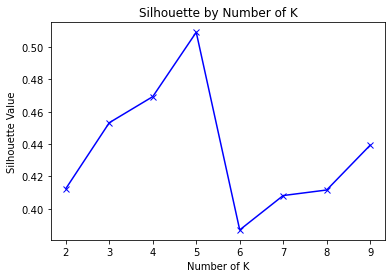

In [9]:
Silhouettes, num_cluseters = get_silhouettes (normalized_df)
print(f"Best K for clustering is {num_cluseters}")
show_silhouettes (Silhouettes)

### Defining clustering for the best K (K=5 in our case)

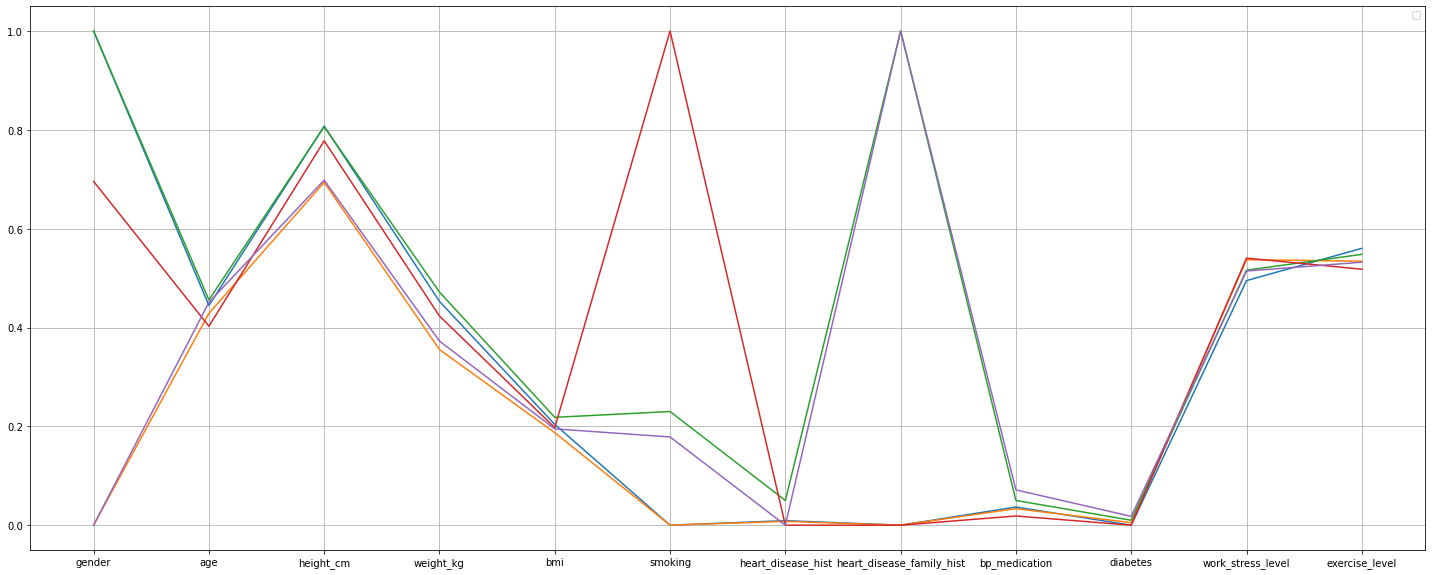

In [10]:
clusterer, preds = get_clusterer(normalized_df, num_cluseters)
show_results(clusterer)

### Arranging the medical tests data (for correct regression measurements):

In [11]:
df_full = df.drop(columns =['patient_id', 'ecg_weight', 'us_weight', 'blood_weight', 'personal_score', 'personal_weight' ])
df_full.replace(["NO","YES", 'Male', "Female"],[0, 1, 1, 0], inplace = True) #convert NO to 0 and Yes to 1
df_full["work_stress_level"].replace(["null/5","0/5","1/5","2/5","3/5","4/5","5/5"],[0,0,0.2,0.4,0.6,0.8,1], inplace = True) #convert male to 0 and female to 1
df_full["exercise_level"].replace(["null/5","0/5","1/5","2/5","3/5","4/5","5/5"],[0,0,0.2,0.4,0.6,0.8,1], inplace = True) #convert male to 0 and female to 1
df_full

,gender,age,height_cm,weight_kg,bmi,ecg_test_score,us_test_score,blood_test_score,overall_score,smoking,heart_disease_hist,heart_disease_family_hist,bp_medication,diabetes,work_stress_level,exercise_level,bp_systolic,bp_diastolic
0,0,41,170,52,18,100,100,98,98,0,0,0,0,0,0.4,0.8,112,75
1,1,26,173,60,20,100,100,90,93,1,0,1,0,0,0.4,0.2,128,84
2,1,38,172,65,22,100,100,84,93,1,0,0,0,0,0.4,0.8,117,79
3,0,39,160,67,26,100,100,91,96,0,0,0,0,0,0.8,0.6,96,61
4,1,33,176,79,26,100,100,67,89,0,0,0,0,0,0.4,0.6,117,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1,29,180,62,19,100,100,89,95,0,0,0,0,0,0.6,0.4,118,73
1355,1,32,176,75,24,100,100,87,92,1,0,1,0,0,0.6,0.2,106,81
1356,0,36,160,51,20,100,100,92,95,0,0,1,0,0,0.6,0.2,133,85
1357,1,27,169,88,31,100,100,83,93,0,0,0,0,0,0.6,0.4,118,81


### Adding the cluster column and splitting the data:

In [12]:
#adding cluster column
allClusters = df_full.assign(cluster=clusterer.labels_)
overall_scores = allClusters['overall_score']
allClusters = allClusters.drop(labels = ['overall_score'], axis=1)
# moving overall_score to the last colum
allClusters = allClusters.assign(overall_score=overall_scores)
allClusters 

#Splitting the Data
cluster_0 = allClusters[allClusters["cluster"] == 0]
cluster_1 = allClusters[allClusters["cluster"] == 1]
cluster_2 = allClusters[allClusters["cluster"] == 2]
cluster_3 = allClusters[allClusters["cluster"] == 3]
cluster_4 = allClusters[allClusters["cluster"] == 4]


In [13]:
cluster_0

,gender,age,height_cm,weight_kg,bmi,ecg_test_score,us_test_score,blood_test_score,smoking,heart_disease_hist,heart_disease_family_hist,bp_medication,diabetes,work_stress_level,exercise_level,bp_systolic,bp_diastolic,cluster,overall_score
4,1,33,176,79,26,100,100,67,0,0,0,0,0,0.4,0.6,117,76,0,89
8,1,46,180,70,22,100,100,89,0,0,0,0,0,0.4,1.0,122,79,0,78
11,1,55,179,72,22,100,100,61,0,0,0,0,0,0.6,1.0,123,85,0,87
17,1,43,180,100,31,100,100,54,0,0,0,0,0,0.4,0.6,124,83,0,85
18,1,48,180,80,25,40,100,79,0,0,0,0,0,0.6,0.4,125,76,0,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,1,37,180,126,39,100,100,82,0,0,0,0,0,0.8,0.2,142,75,0,92
1352,1,24,183,80,24,100,100,91,0,0,0,0,0,0.8,0.4,130,76,0,95
1354,1,29,180,62,19,100,100,89,0,0,0,0,0,0.6,0.4,118,73,0,95
1357,1,27,169,88,31,100,100,83,0,0,0,0,0,0.6,0.4,118,81,0,93


In [8]:
#Data exploring f.e cluster: 
profile0 = ProfileReport(cluster_0, title="Cluster 0", explorative=True)
profile0.to_file("Cluster 0.html")
profile1 = ProfileReport(cluster_1, title="Cluster 1", explorative=True)
profile1.to_file("Cluster 1.html")
profile2 = ProfileReport(cluster_2, title="Cluster 2", explorative=True)
profile2.to_file("Cluster 2.html")
profile3 = ProfileReport(cluster_3, title="Cluster 3", explorative=True)
profile3.to_file("Cluster 3.html")
profile4 = ProfileReport(cluster_4, title="Cluster 4", explorative=True)
profile4.to_file("Cluster 4.html")

NameError: name 'cluster_0' is not defined

## Linear regression model per cluster:

In [19]:
counter = 1;
for cluster in [cluster_0,cluster_1,cluster_2,cluster_3,cluster_4]:
    print("----------------------------------------------------------------------")
    print(f"Inside Cluster number {counter}, tests to find the least significant medical test:")
    print("----------------------------------------------------------------------")
    train, test = train_test_split(cluster.values, test_size=0.2)
    reg = LinearRegression(copy_X=True).fit(train[:,:-1],train[:,-1])
    print("\n")
    print("With all test, the score is:",reg.score(test[:,:-1], test[:,-1]))
    print("\n")
    for feature in [5,6,7]:
        train_one_test_missing = np.delete(train, feature, 1)
        reg = LinearRegression(copy_X=True).fit(train_one_test_missing[:,:-1],train[:,-1])
        test_one_test_missing = np.delete(test, feature, 1)
        print(f"The Predictaion score With all test, except the test: '{cluster.columns[feature]}', is:\t",reg.score(test_one_test_missing[:,:-1], test[:,-1]))
        print("\n")
    counter += 1   

----------------------------------------------------------------------
Inside Cluster number 1, tests to find the least significant medical test:
----------------------------------------------------------------------


With all test, the score is: 0.9322348711648244


The Predictaion score With all test, except the test: 'ecg_test_score', is:	 0.5659144535477199


The Predictaion score With all test, except the test: 'us_test_score', is:	 0.6957216982684633


The Predictaion score With all test, except the test: 'blood_test_score', is:	 0.7674248229100848


----------------------------------------------------------------------
Inside Cluster number 2, tests to find the least significant medical test:
----------------------------------------------------------------------


With all test, the score is: 0.8663182837456858


The Predictaion score With all test, except the test: 'ecg_test_score', is:	 0.42967162745177856


The Predictaion score With all test, except the test: 'us_test_score

## Decision Tree model per cluster:

In [14]:
def get_XY(ndarray):
    ndarray= ndarray.values
    X=ndarray[:,:-1]
    Y= ndarray[:,-1]
    return X,Y
#I've chaned the data format a bit so I chaned the func from the tutorial

def get_clf(X,Y):
    clf= DecisionTreeClassifier( criterion="gini",  min_impurity_decrease=0.01)
    clf.fit(X, Y)
    return(clf)

def get_pred(classifier, X):
    y_pred = classifier.predict(X)
    return(y_pred)

def get_accuracy(test,pred): 
    accuracy = metrics.accuracy_score(test, pred)
    return accuracy

In [15]:
counter = 1;
for cluster in [cluster_0,cluster_1,cluster_2,cluster_3,cluster_4]:
    print("----------------------------------------------------------------------")
    print(f"Inside Cluster number {counter}, tests to find the least significant medical test:")
    print("----------------------------------------------------------------------")
    data_train, data_test= train_test_split(cluster.values, test_size=0.2)
    data_train_X = data_train[:,:-1]
    data_train_y = data_train[:,-1]
    data_test_X = data_test[:,:-1]
    data_test_y = data_test[:,-1]
    clf=get_clf(data_train_X,data_train_y)
    y_pred = get_pred(clf, data_test_X)
    clf_accuracy=get_accuracy(data_test_y,y_pred) 
    print("\n")
    print("With all medical tests, the accuracy is:",clf_accuracy)
    print("\n")
    for feature in [5,6,7]:
        train_one_test_missing = np.delete(data_train_X, feature, 1)
        clf=get_clf(train_one_test_missing,data_train_y)
        test_one_test_missing = np.delete(data_test_X, feature, 1)
        y_pred = get_pred(clf, test_one_test_missing)
        clf_accuracy=get_accuracy(data_test_y,y_pred)
        
        print(f"The predictaion score With all test, except the test: '{cluster.columns[feature]}', is:\t",clf_accuracy)
        print("\n")
    counter += 1    

----------------------------------------------------------------------
Inside Cluster number 1, tests to find the least significant medical test:
----------------------------------------------------------------------


With all medical tests, the accuracy is: 0.4961832061068702


The predictaion score With all test, except the test: 'ecg_test_score', is:	 0.4961832061068702


The predictaion score With all test, except the test: 'us_test_score', is:	 0.5038167938931297


The predictaion score With all test, except the test: 'blood_test_score', is:	 0.1450381679389313


----------------------------------------------------------------------
Inside Cluster number 2, tests to find the least significant medical test:
----------------------------------------------------------------------


With all medical tests, the accuracy is: 0.5512820512820513


The predictaion score With all test, except the test: 'ecg_test_score', is:	 0.5384615384615384


The predictaion score With all test, except t

In [16]:
import pydotplus
from IPython.display import Image

def get_predictors_names(dataframe):
    names = list(dataframe.columns)
    predictors_names=names[:-1]
    return predictors_names

def get_graph(clf,df_predictors_names, class_names):
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names=df_predictors_names, class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data) 
    return graph

def save_graph(grpah):
    graph.write_pdf("DT flights.pdf")
    graph.write_jpg("DT flights.jpg")
    save_graph(graph)

def get_image(graph):
    image = Image(graph.create_png())
    return image
data_train, data_test= train_test_split(cluster_0.values, test_size=0.2)
data_train_X = data_train[:,:-1]
data_train_y = data_train[:,-1]
data_test_X = data_test[:,:-1]
data_test_y = data_test[:,-1]



### Optimizing "buckets" for classification decition tree (narrowing down the posibillities) to prevent an overfitting / too complicated model

In [31]:
def set_buckets(df, unumber_of_buckets):
    data_frame = df.copy()
    bucket_size = 100/unumber_of_buckets
    data_frame["overall_score"] = data_frame["overall_score"].apply(lambda x: int(x/bucket_size))
    return data_frame

clusters_w_buckets_list=[]
for bucket in [5,10,20]:
    clusters_w_buckets_list=[]
    for cluster in [cluster_0,cluster_1,cluster_2,cluster_3,cluster_4]:
        clusters_w_buckets_list.append(set_buckets(cluster,bucket))
        
    for i, cluster in enumerate(clusters_w_buckets_list):
        print("----------------------------------------------------------------------")
        print(f"Inside Cluster number {i}, with splitting the overall_score for {bucket} buckets,\n tests to find the least significant medical test:")
        print("----------------------------------------------------------------------")
        data_train, data_test= train_test_split(cluster.values, test_size=0.2)
        data_train_X = data_train[:,:-1]
        data_train_y = data_train[:,-1]
        data_test_X = data_test[:,:-1]
        data_test_y = data_test[:,-1]
        clf=get_clf(data_train_X,data_train_y)
        y_pred = get_pred(clf, data_test_X)
        clf_accuracy=get_accuracy(data_test_y,y_pred) 
        print("\n")
        print("With all medical tests, the accuracy is:",clf_accuracy)
        print("\n")
        for feature in [5,6,7]:
            train_one_test_missing = np.delete(data_train_X, feature, 1)
            clf=get_clf(train_one_test_missing,data_train_y)
            test_one_test_missing = np.delete(data_test_X, feature, 1)
            y_pred = get_pred(clf, test_one_test_missing)
            clf_accuracy=get_accuracy(data_test_y,y_pred)

            print(f"The predictaion score With all test, except the test: '{cluster.columns[feature]}', is:\t",clf_accuracy)
            print("\n")
  


----------------------------------------------------------------------
Inside Cluster number 0, with splitting the overall_score for 5 buckets,
 tests to find the least significant medical test:
----------------------------------------------------------------------


With all medical tests, the accuracy is: 0.9541984732824428


The predictaion score With all test, except the test: 'ecg_test_score', is:	 0.9083969465648855


The predictaion score With all test, except the test: 'us_test_score', is:	 0.9312977099236641


The predictaion score With all test, except the test: 'blood_test_score', is:	 0.9389312977099237


----------------------------------------------------------------------
Inside Cluster number 1, with splitting the overall_score for 5 buckets,
 tests to find the least significant medical test:
----------------------------------------------------------------------


With all medical tests, the accuracy is: 0.9358974358974359


The predictaion score With all test, except t

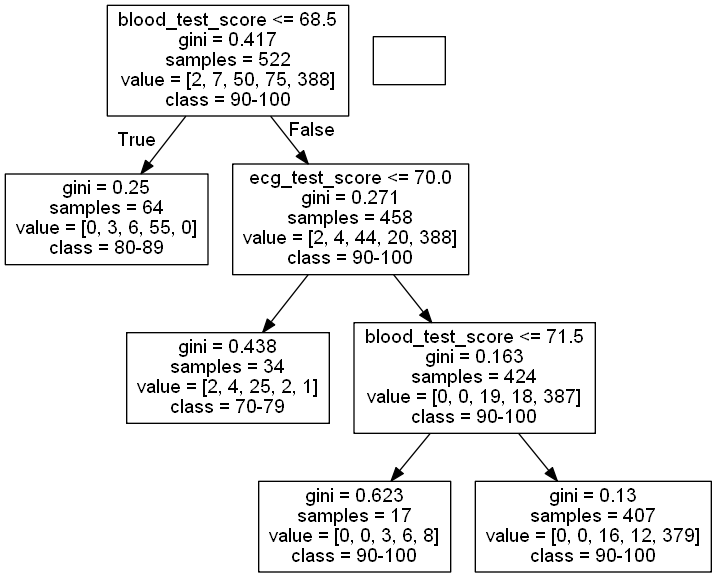

In [38]:
map_dict = {
    0: "1-9",
    1: "10-19",
    2: "20-29",
    3: "30-39",
    4: "40-49",
    5: "50-59",    
    6: "60-69",    
    7: "70-79",     
    8: "80-89", 
    9: "90-100",
    10:"90-100"
}

cluster_final = cluster_0.drop(columns ="us_test_score")
cluster_final = set_buckets(cluster_final,10)
df_predictors_names = get_predictors_names(cluster_final)
data_train, data_test= train_test_split(cluster_final.values, test_size=0.2)
data_train_X = data_train[:,:-1]
data_train_y = data_train[:,-1]

clf=get_clf(data_train_X,data_train_y)
class_names= np.unique(data_train_y)
labels=[]
for label in class_names:
    labels.append(map_dict[int(label)])
    
graph =get_graph(clf,df_predictors_names, labels)
image = get_image(graph)
image

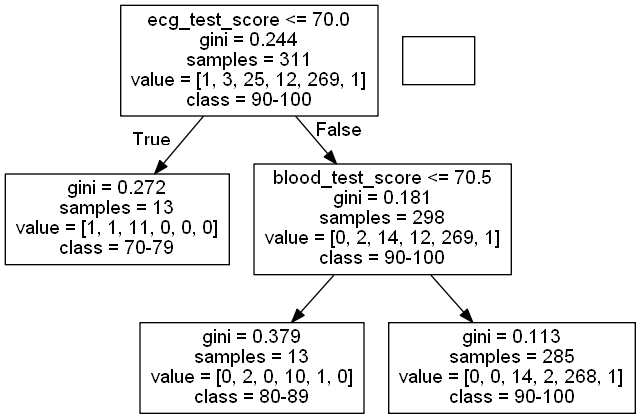

In [91]:
cluster_final = cluster_1.drop(columns ="us_test_score")
cluster_final = set_buckets(cluster_final,10)
df_predictors_names = get_predictors_names(cluster_final)
data_train, data_test= train_test_split(cluster_final.values, test_size=0.2)
data_train_X = data_train[:,:-1]
data_train_y = data_train[:,-1]

clf=get_clf(data_train_X,data_train_y)
class_names= np.unique(data_train_y)
labels=[]
for label in class_names:
    labels.append(map_dict[int(label)])
    
graph =get_graph(clf,df_predictors_names, labels)
image = get_image(graph)
image

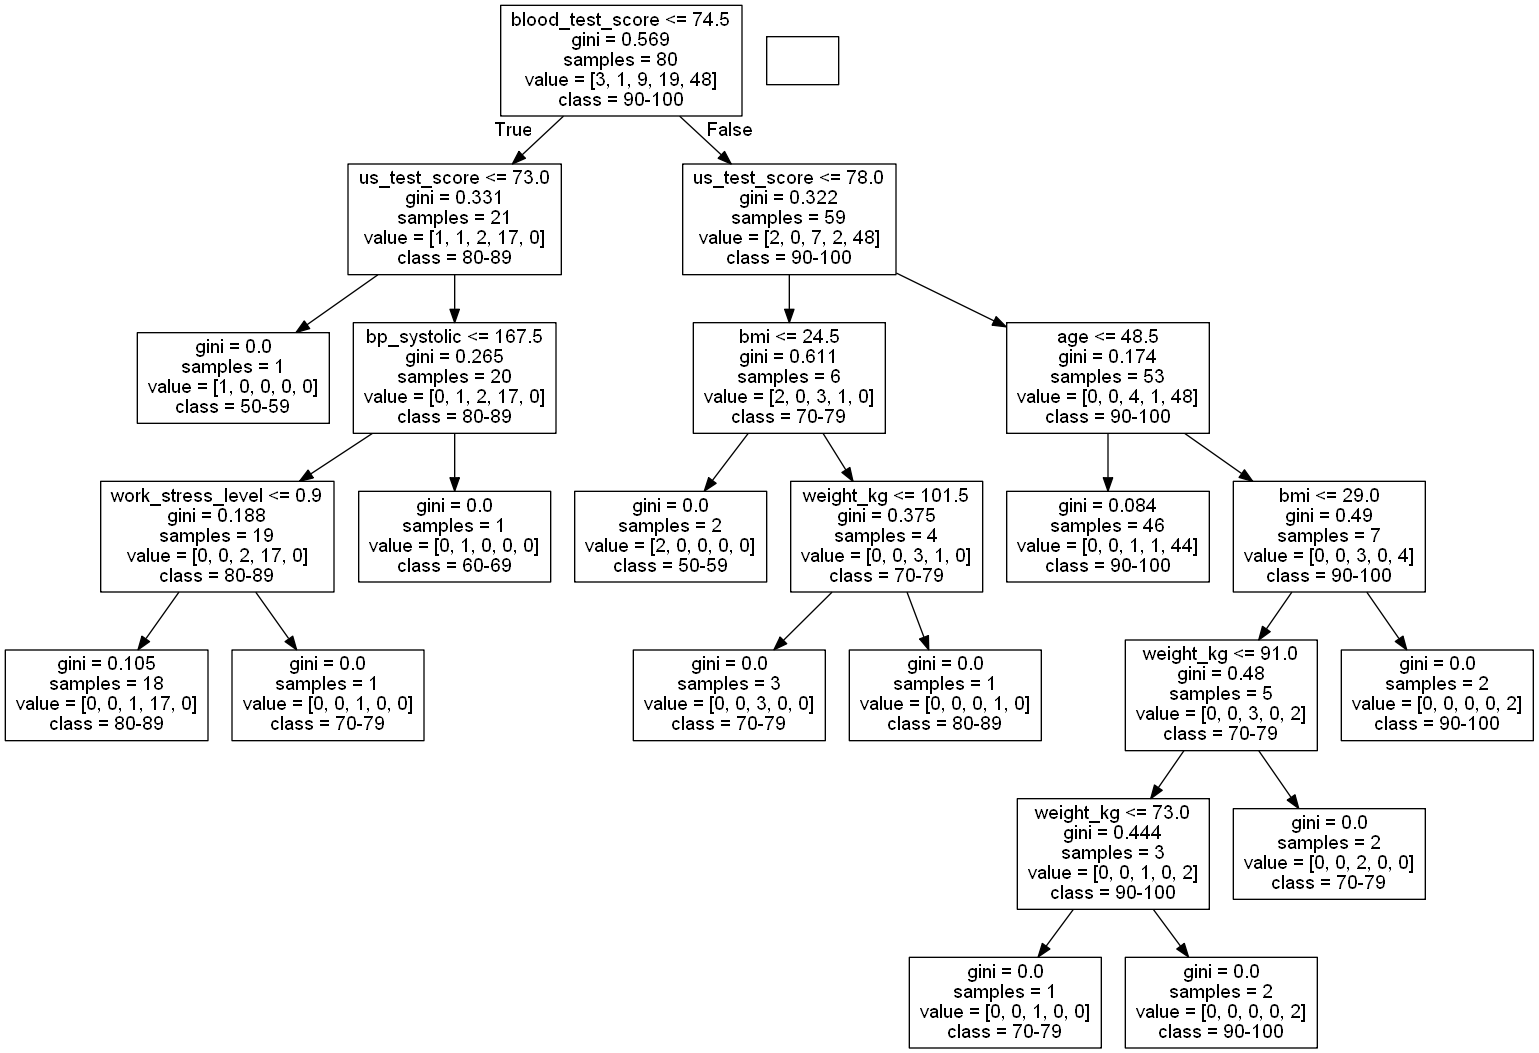

In [96]:
cluster_final = cluster_2.drop(columns ="ecg_test_score")
cluster_final = set_buckets(cluster_final,10)
df_predictors_names = get_predictors_names(cluster_final)
data_train, data_test= train_test_split(cluster_final.values, test_size=0.2)
data_train_X = data_train[:,:-1]
data_train_y = data_train[:,-1]

clf=get_clf(data_train_X,data_train_y)
class_names= np.unique(data_train_y)
labels=[]
for label in class_names:
    labels.append(map_dict[int(label)])
    
graph =get_graph(clf,df_predictors_names, labels)
image = get_image(graph)
image

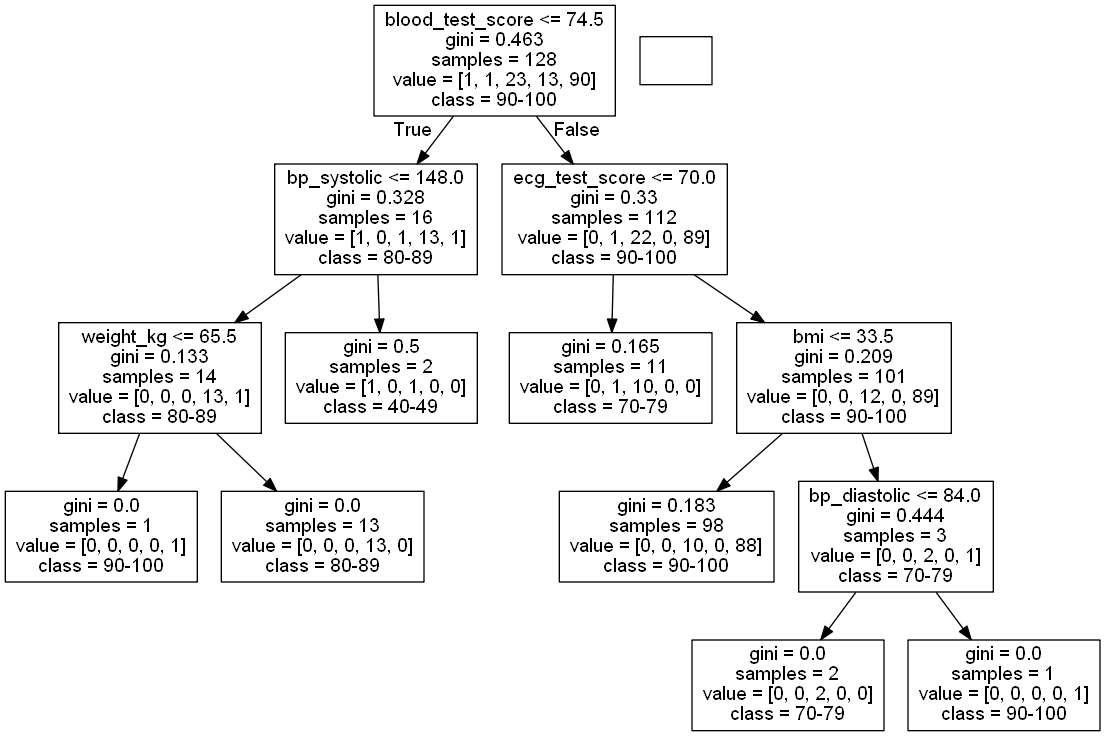

In [97]:
cluster_final = cluster_3.drop(columns ="us_test_score")
cluster_final = set_buckets(cluster_final,10)
df_predictors_names = get_predictors_names(cluster_final)
data_train, data_test= train_test_split(cluster_final.values, test_size=0.2)
data_train_X = data_train[:,:-1]
data_train_y = data_train[:,-1]

clf=get_clf(data_train_X,data_train_y)
class_names= np.unique(data_train_y)
labels=[]
for label in class_names:
    labels.append(map_dict[int(label)])
    
graph =get_graph(clf,df_predictors_names, labels)
image = get_image(graph)
image

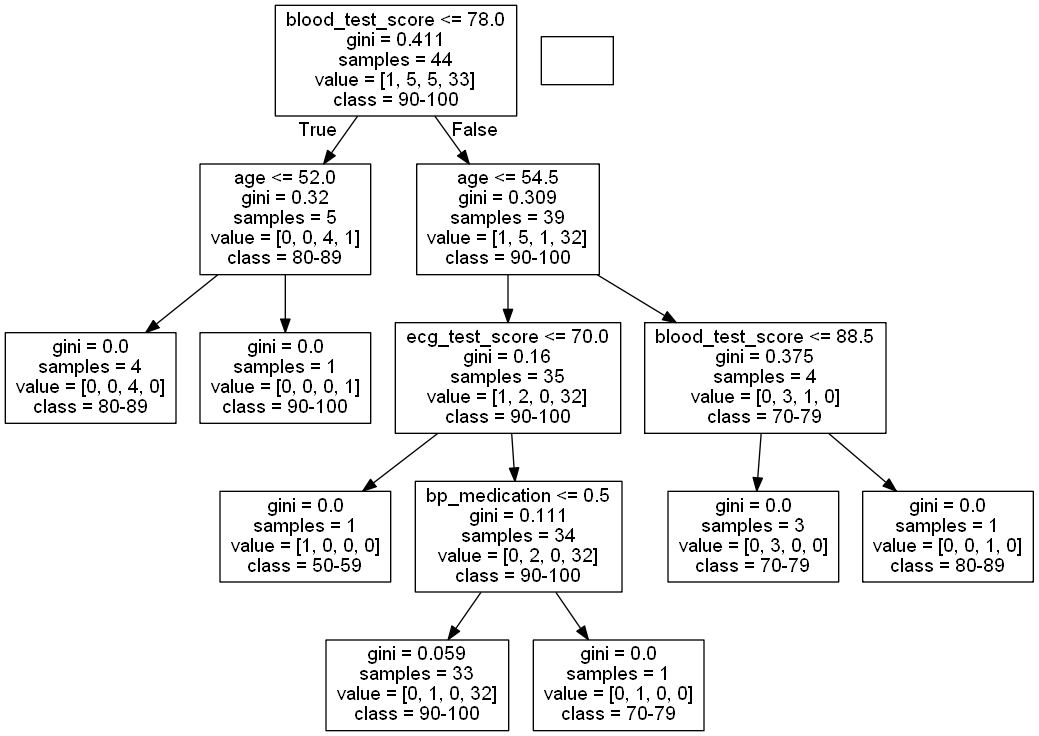

In [98]:
cluster_final = cluster_4.drop(columns ="us_test_score")
cluster_final = set_buckets(cluster_final,10)
df_predictors_names = get_predictors_names(cluster_final)
data_train, data_test= train_test_split(cluster_final.values, test_size=0.2)
data_train_X = data_train[:,:-1]
data_train_y = data_train[:,-1]

clf=get_clf(data_train_X,data_train_y)
class_names= np.unique(data_train_y)
labels=[]
for label in class_names:
    labels.append(map_dict[int(label)])
    
graph =get_graph(clf,df_predictors_names, labels)
image = get_image(graph)
image

In [64]:
from sklearn.metrics import confusion_matrix, recall_score
print("Confusion Matrix Tree : \n", confusion_matrix(data_test[:,-1], get_pred(clf,data_test[:,0:-1])),"\n")


Confusion Matrix Tree : 
 [[  0   1   0   0]
 [  0   1   4   7]
 [  0   0  10   6]
 [  0   0   0 102]] 

